# Optimal Subspace Inference for the Laplace Approximation of Bayesian Neural Networks

Bayesian modelling is an elegant and flexible method to quantify uncertainties of parametric models. Treating the parameters $\theta \in \mathbb{R}^q$ of the model as random variables allows to incorporate model (or epistemic) uncertainty. Bayesian neural networks implement this idea for neural networks. In practice, however,
full posterior inference over Bayesian neural networks is intractable due to the large number of parameters that define the neural networks.

## Laplace approximation
One commonly used Bayesian method is the Laplace approximation in which the posterior is approximated by a Normal distribution whose mean is given by the maximium a posteriori estimate and the covariance $\Psi \in \mathbb{R}^{q \times q}$ of this distribution is a function of the inverse Hessian of the neural network. However, the Hessian has memory complexity $q^2$ which is infeasible to handle for neural networks with $q \gg 1$ many parameters. Therefore, a straightforward application of the Laplace approximation isn't possible.

But do we really need all $q$ parameters to obtain a decent estimate of the Hessian? The answer is negative, often a fraction of the parameters is sufficient. We study the performance of subspace models that have fewer degrees of freedom than the full Laplace approximation. Concretely, the posterior covariance matrix is mapped on a subspace $(P^\intercal \Psi^{-1} P)^{-1} \in \mathbb{R}^{s\times s}$ with $s \ll q$. This quantity is finally used to compute the covariance $\Sigma_P$ of the predictive distribution of the subspace model
$$  
    p(y|x,\mathcal{D}) = \mathcal{N}(y|f_{\hat{\theta}}(x), \Sigma_P + \sigma^{2} \mathbb{1})
    \quad \text{with} \quad
    \Sigma_P = J P (P^\intercal \Psi^{-1} P)^{-1} P^\intercal J^\intercal,
$$
which is also Normal. $J$ is the Jacobian of the neural network evaluated at the test sample $x$ and $\sigma$ is the standard deviation of the data. $P \in \mathbb{R}^{q \times s}$ is the projector that maps the full posterior covariance $\Psi$ onto a smaller dimensional subspace. The full model can formally be obtained by chosing $P=\mathbb{1}$. The quality of the subspace model is fully determined by the choice of $P$.

This notebook guides you through the main ideas of subspace models after a Laplace approximations is applied. For a more detailed theoretical analysis and experimental case studies please consult the linked paper. 

## Toy example 
To illustrate the principles of subspace models, we study the simple function
$$ g(x) = \sin\left(\frac{x}{2}\right) \cos\left(\frac{x}{4}\right) $$
trained on a synthetic dataset.

## Outline of the notebook
1. We define the configurations, to fix the problem setting.
2. Next we load the dataset and the model and plot its performance to get an idea of the problem itself.
3. We compute the full dimensional Laplace approximation. The projector $P$ is called `p=None` in this case, because no projector (or the identity map) is chosen.
5. We compute the subspace models defined in 1. The subspace models developed in this work are called low rank approximations which we indicate in the projector name by `p=lowrank...` and the methods from the literature are called `p=subset...`. The best possible approximation for a certain dimension $s$ is called `p=lowrankoptimal...`.
6. Then we study the logarithm of the trace and relative error of different subspace models to measure their performance. 
5. Lastly we study the test log-likelihood of the posterior predictive that is commonly called negative log-likelihood (nll).

In [1]:
# load the relevant libraries
import math

import torch
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.pyplot as plt

from omegaconf import OmegaConf

from projector.projector1d import create_jacobian_data_iterator
from projector.projector import get_P, get_IPsi 
from linearized_model.low_rank_laplace import (
    compute_Sigma,
    compute_Sigma_P,
    IPsi_predictive,
)
from linearized_model.approximation_metrics import (
    collect_NLL, 
    update_performance_metrics,
)
from compute_metrics import update_Sigma_metrics
from get_epistemic_covariance import get_regression_likelihood_sigma, get_s_list

from pred_model.mlp import MLP
from data.dataset import DatasetGenerator
from color_map import get_color, get_color2

/home/faller01/san/projects/OptProjector/compute_metrics.py:49: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config", config_name="config")
/home/faller01/san/projects/OptProjector/get_epistemic_covariance.py:89: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config", config_name="config")


## 1 Configuration
An explaination of the configurations can be found in the `config` files of the repository. (In particular `Sigma.yaml`)

In [2]:
# configurations
device_torch="cuda:0"

cfg = OmegaConf.create({
    "projector" : {"batch_size": 100, 
                   "n_batches": 10,
                   "chunk_size": None, 
                   "v": {"batch_size": 100,
                        "n_batches": None},
                   "s" : {"min": 1,
                           "max": 60,
                           "n":58},
                   "s_max_regularized": 60,
                   "sigma": {"prior_precision": 1.0,
                             "method": {"p": None,
                                        "psi": "ggnit"}},
                   "data_std": 0.1 # if None the standard deviation is estimated from the data.
        },
    "data": {"is_classification": False,
            "swag_kwargs":{"swag_n_snapshots": 10,
                          "swag_snapshot_freq": 1,
                          "swag_lr": 0.01},
            },
    "dtype": "float32",
    "device_torch": device_torch,
    "seed": 1
})

# s-values to study
s_list = get_s_list(
        s_min = cfg.projector.s.min,
        s_max = cfg.projector.s_max_regularized,
        s_n = cfg.projector.s.n
    )

# methods to study. 
# The first entry is the projector type `p`.
# The second entry is the covariance matrix of the posterior `psi`
methods = [("lowrank-kron", "ggnit"), # lowrank method with KFAC approximation
           ("lowrankoptimal-ggnit", "ggnit"), # best possible approximation
          ("subset-magnitude", "ggnit"), # subset method from the literature
          ("subset-diag", "ggnit")] # subset method from the literature

# methods that are evaluated
methods_evaluate = methods + [("None", "ggnit")]

# store some results
results = {} # predictive covariance
metrics ={} # relative error, log-trace, nll

## 2. Predictions of the model
Next we visualize the problem for which we quantify the uncertainty. We use a simple multi-layer perceptron (MLP) to make predictions.

In [3]:
def g(x):
    """ True function """
    return np.sin(x / 4) * np.cos(x / 2)

x = np.arange(-20, 20, step=0.3, dtype="float32")
y = g(x)

# load data
data = np.load("utils/Sinus_NTrain100.npz")
sigma = data["sigma"]
x_train, y_obs_train = data["X_tr"], data["Y_tr"]
x_test, y_obs_test = data["X_te"], data["Y_te"]

# create dataset
train_data = DatasetGenerator(x_train, y_obs_train, dtype="float32")
test_data = DatasetGenerator(x_test, y_obs_test, dtype="float32")
dl_test = DataLoader(test_data, batch_size=cfg.projector.batch_size)
dl_train = DataLoader(train_data, batch_size=cfg.projector.batch_size)

# load model
model = MLP(n_hidden=1024, n_layer=1, init_var_y=0).to(cfg.device_torch)
model.eval()
state_dict = torch.load(f"utils/epoch1499-step1500_dict.ckpt")
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [4]:
# predictions 
X = torch.tensor(x.reshape(-1, 1)).to(cfg.device_torch)
y_hat = model(X).detach().cpu()

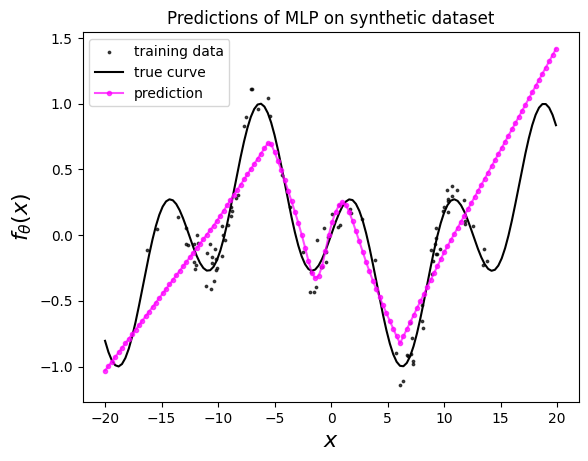

In [5]:
plt.scatter(x_train, y_obs_train, label="training data", alpha=0.7, 
    color="black", s=3)
plt.plot(x, y, label="true curve", color="black")
plt.plot(x, y_hat.numpy(), alpha=0.7, color="magenta", marker="o", 
         markersize=3, label="prediction")
plt.ylabel(r"$f_{\theta}(x)$", fontsize=16)
plt.xlabel(r"$x$", fontsize=16)
plt.title("Predictions of MLP on synthetic dataset")
plt.legend()

## 3. Full Laplace model
Compute the covariance matrix $\Sigma$ of the predicitive distribution for the full Laplace approximation

In [6]:
#  The following objects create upon call an iterator over the jacobian
def create_proj_jac_it():
    return create_jacobian_data_iterator(
        dataset=test_data,
        model=model,
        batch_size=cfg.projector.batch_size,
        number_of_batches=cfg.projector.n_batches,
        device=cfg.device_torch,
        dtype=getattr(torch, cfg.dtype),
        chunk_size=cfg.projector.chunk_size,
)

# Obtain predictive covariance
IPsi = get_IPsi(
        method="ggnit",
        cfg=cfg,
        model=model,
        data=train_data,
        path="" # only relevant if `method=="loadfile"`
)
Sigma = compute_Sigma(IPsi=IPsi, J_X=create_proj_jac_it).detach()
results.setdefault("ggnit", {}).setdefault("None", {}).setdefault("Sigma", Sigma)

iterator_wise_quadratic_form: 4it [00:01,  3.32it/s]


tensor([[ 3.1588e-01,  1.9882e-05, -6.2892e-06,  ...,  4.2265e-02,
          5.9845e-05, -1.3375e-04],
        [-1.8311e-04,  7.3818e-02,  1.0334e-04,  ...,  2.4998e-04,
          3.9921e-03,  5.6893e-05],
        [ 2.7582e-04,  8.9744e-05,  5.5965e-01,  ..., -2.8342e-04,
         -1.0166e-05,  6.2221e-01],
        ...,
        [ 4.2452e-02,  1.3362e-04, -2.0059e-04,  ...,  2.8503e-01,
         -8.9654e-06, -9.6060e-05],
        [ 7.0870e-05,  3.9909e-03, -1.2198e-05,  ..., -2.1219e-05,
          6.0512e-02, -9.3281e-06],
        [ 2.5007e-04,  4.4963e-05,  6.2221e-01,  ..., -3.0759e-04,
         -6.4259e-06,  8.2115e-01]], device='cuda:0')

## 4. Subspace models
Compute the predictive covariance matrices $\Sigma_{P_i}$ of the predicitive distribution for all subspace models. We obtain a different projector $P$ for each dimension $s$.

In [7]:
for (p, psi) in methods:
    cfg.projector.sigma.method.p = p
    cfg.projector.sigma.method.psi = psi
    
    #  The following objects create upon call an iterator over the jacobian
    def create_proj_jac_it():
        return create_jacobian_data_iterator(
            dataset=test_data,
            model=model,
            batch_size=cfg.projector.batch_size,
            number_of_batches=cfg.projector.n_batches,
            device=cfg.device_torch,
            dtype=getattr(torch, cfg.dtype),
            chunk_size=cfg.projector.chunk_size,
    )
    
    # Obtain predictive covariance
    IPsi = get_IPsi(
            method=psi,
            cfg=cfg,
            model=model,
            data=train_data,
            path="" # only relevant if `method=="loadfile"`
    )
    P = get_P(
        cfg.projector.sigma.method.p, 
        cfg, 
        model, 
        data_Psi=train_data, 
        data_J=train_data if not "lowrankoptimal" in cfg.projector.sigma.method.p \
        else test_data, # theoretical optimal solution needs test_data 
        path="",
        s=cfg.projector.s_max_regularized,
    )
    create_Sigma_P_s_it = compute_Sigma_P(
            P=P,
            IPsi=IPsi,
            J_X=create_proj_jac_it,
            s_iterable=s_list,
        )()
    results.setdefault(psi, {}).setdefault(p, {})
    for s, Sigma_P_s in zip(s_list, create_Sigma_P_s_it):
        name_Sigma = f"SigmaP{s}" if s is not None else "SigmaP"
        results[psi][p][name_Sigma] = Sigma_P_s.detach()

iterator_wise_quadratic_form: 1it [00:00, 21.50it/s]
iterator_wise_matmul: 1it [00:00, 131.50it/s]
iterator_wise_matmul: 4it [00:00, 166.94it/s]
iterator_wise_quadratic_form: 4it [00:01,  3.47it/s]
iterator_wise_matmul: 4it [00:00, 170.75it/s]
iterator_wise_matmul: 4it [00:00, 180.24it/s]
iterator_wise_matmul: 4it [00:00, 283.72it/s]
iterator_wise_matmul: 4it [00:00, 245.02it/s]


# Compute and plot the log-trace and the relative error
The relative error
$$\frac{\|\Sigma - \Sigma_{P}\|_F}{\|\Sigma\|_F}$$
is the normalized Frobenius norm between the difference of the full covariance matrix $\Sigma$ and the reduced covariance matrix $\Sigma_p$. If the relative error is exactly zero, both covariance matrices coincide. Hence, the relative error is a good measure to compare the approximation quality of the subspace models. If a small number of eigenvalues dominate $\Sigma$ a good approximation is possible. Chosing these eigenpairs in the subspace model should yield a low relative error. Since $\Sigma$ is semi-positive definite and if $0 \leq \mathrm{Tr} \Sigma_{P_1} < \mathrm{Tr} \Sigma_{P_2} \leq \mathrm{Tr} \Sigma$, we conclude that $\Sigma_{P_2}$ is a better approximation than $\Sigma_{P_1}$.

We shall see that the log-trace and the relative error (anti-)correlate well.

In [8]:
Sigma = results["ggnit"]["None"]["Sigma"].detach()
for (p, psi) in methods_evaluate:
    metrics.setdefault(psi, {}).setdefault(p, {})
    for s in s_list:
        Sigma_approx = results[psi][p][f"SigmaP{s}"] if not p=="None" else Sigma
        update_Sigma_metrics(
            metrics_dict=metrics[psi][p],
            Sigma_approx=Sigma_approx,
            Sigma=Sigma,
        )

/home/faller01/san/projects/OptProjector/linearized_model/approximation_metrics.py:34: RuntimeWarning: divide by zero encountered in log
  return np.log(torch.trace(Sigma_approx).item())


Define some functions to make the plotting appearance universal.

In [9]:
p_names = {
    'kron': "KFAC",
    'magnitude': "Magnitude",
    'swag': "SWAG",
    'diag': "Diagonal",
    'None': "Full",
    'ggnit': "GGN"
}

psi_names ={
    "ggnit": "GGN",
    "kron": "KFAC",
    "diag": "Diagonal",
}

p_method = {
    "lowrank": "lowrank",
    "subset": "subset",
    "None": "None",
    "lowrankoptimal": "lowrankopt"
}

def get_linestyle(group: str) -> str:
    if group=="lowrank":
        return "-"
    elif group=="subset":
        return "--"
    elif group=="None":
        return ":"
    elif group=="lowrankoptimal":
        return "-."
    else:
        raise NotImplementedError

def get_p_name(method: str) -> str:
    if not method in p_names.keys():
        raise NotImplementedError
    return p_names[method]

def get_psi_name(method: str) -> str:
    if not method in psi_names.keys():
        raise NotImplementedError
    return psi_names[method]

def get_p_method(method: str) -> str:
    if not method in p_method.keys():
        raise NotImplementedError
    return p_method[method]

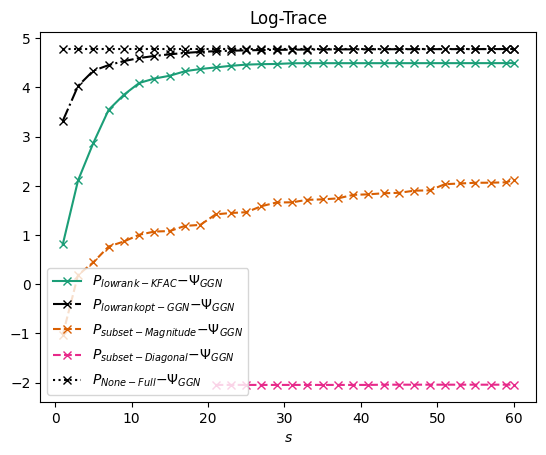

In [10]:
plt.tight_layout()
for (p, psi) in methods_evaluate:
    try:
        p_group, p_name = p.split("-")
    except:
        p_group, p_name = "None", "None"
    p_name_plot = get_p_name(p_name)
    # generate label
    psi_name_plot = get_psi_name(psi)
    label_method = f"{get_p_method(p_group)}-"
    label_psi = fr"$-\Psi_{{{psi_name_plot}}}$"
    label = fr"$P_{{{label_method}{p_name_plot}}}${label_psi}"
    
    plt.plot(s_list, metrics[psi][p]["logtrace"],
            label=label,
            color=get_color(p_name) if psi_name_plot=="GGN" else get_color2(p_name),
            linestyle=get_linestyle(p_group),
            marker="x")
    plt.title("Log-Trace")
    plt.xlabel(r"$s$")
plt.legend()

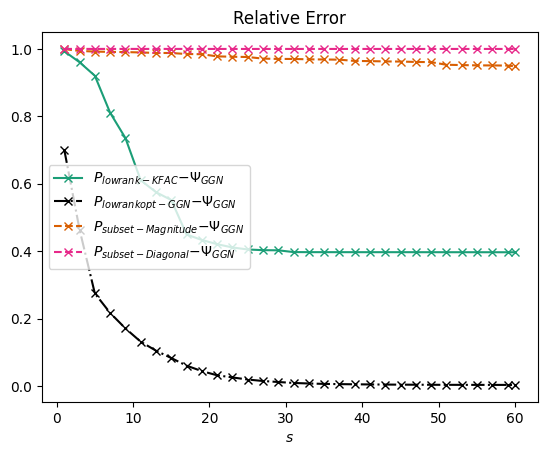

In [22]:
plt.tight_layout()
for (p, psi) in methods_evaluate:
    if p=="None":
        continue
    else:
        p_group, p_name = p.split("-")
    p_name_plot = get_p_name(p_name)
    # generate label
    psi_name_plot = get_psi_name(psi)
    label_method = f"{get_p_method(p_group)}-"
    label_psi = fr"$-\Psi_{{{psi_name_plot}}}$"
    label = fr"$P_{{{label_method}{p_name_plot}}}${label_psi}"
    
    plt.plot(s_list, metrics[psi][p]["rel_error"],
            label=label,
            color=get_color(p_name) if psi_name_plot=="GGN" else get_color2(p_name),
            linestyle=get_linestyle(p_group),
            marker="x")
    plt.title("Relative Error")
    plt.xlabel(r"$s$")
plt.legend()

## 6. NLL
The NLL is often chosen as a metric to evaluate different uncertainty methods. However, for subspace models the NLL is unsatisfying. One shortcoming of the NLL is that it sometimes assigns to subspace models a higher value than to the full Laplace approximation, but the full Laplace approximation should quantify the uncertainty best in all cases we study, because all other methods are approximations thereof.

In [12]:
if cfg.projector.data_std is None:
# for regression problems estimate the sigma of the likelihood
    regression_likelihood_sigma = get_regression_likelihood_sigma(
        model, dl_train, cfg.data.is_classification, cfg.device_torch
    )
elif cfg.projector.data_std > 0:
    regression_likelihood_sigma = cfg.projector.data_std
else:
    raise ValueError("Insert a None or a positive number for `data_std`.")
results['regression_likelihood_sigma'] = regression_likelihood_sigma
print("The data standard deviation is ", regression_likelihood_sigma)

The data standard deviation is  0.1


In [13]:
#  The following objects create upon call an iterator over the jacobian
def create_proj_jac_it():
    return create_jacobian_data_iterator(
        dataset=test_data,
        model=model,
        batch_size=cfg.projector.batch_size,
        number_of_batches=cfg.projector.n_batches,
        device=cfg.device_torch,
        dtype=getattr(torch, cfg.dtype),
        chunk_size=cfg.projector.chunk_size,
)

# Obtain predictive covariance
IPsi = get_IPsi(
        method=psi,
        cfg=cfg,
        model=model,
        data=train_data,
        path="" # only relevant if `method=="loadfile"`
)
Sigma = compute_Sigma(IPsi=IPsi, J_X=create_proj_jac_it).detach()

# compute predictive to compute nll
predictive = IPsi_predictive(
    model=model,
    IPsi=IPsi,
    P=None,
    chunk_size=cfg.projector.chunk_size,
    regression_likelihood_sigma=regression_likelihood_sigma,
)

# compute nll
predictive_s = lambda X: predictive(X=X, s=0)
nll_value = collect_NLL(
    predictive=predictive_s,
    dataloader=dl_test,
    is_classification=cfg.data.is_classification,
    reduction="mean",
    verbose=False,
    device=cfg.device_torch).item()
for s in s_list:
    update_performance_metrics(metrics["ggnit"]["None"], "nll", nll_value)

iterator_wise_quadratic_form: 4it [00:01,  3.48it/s]


In [14]:
#  The following objects create upon call an iterator over the jacobian
for (p, psi) in methods:
    cfg.projector.sigma.method.p = p
    cfg.projector.sigma.method.psi = psi
    
    #  The following objects create upon call an iterator over the jacobian
    def create_proj_jac_it():
        return create_jacobian_data_iterator(
            dataset=test_data,
            model=model,
            batch_size=cfg.projector.batch_size,
            number_of_batches=cfg.projector.n_batches,
            device=cfg.device_torch,
            dtype=getattr(torch, cfg.dtype),
            chunk_size=cfg.projector.chunk_size,
    )
    
    # Obtain predictive covariance
    IPsi = get_IPsi(
            method=psi,
            cfg=cfg,
            model=model,
            data=train_data,
            path="" # only relevant if `method=="loadfile"`
    )
    P = get_P(
        cfg.projector.sigma.method.p, 
        cfg, 
        model, 
        data_Psi=train_data, 
        data_J=train_data if not "lowrankoptimal" in cfg.projector.sigma.method.p \
        else test_data, # theoretical optimal solution needs test_data 
        path="",
        s=cfg.projector.s_max_regularized,
    )
    create_Sigma_P_s_it = compute_Sigma_P(
            P=P,
            IPsi=IPsi,
            J_X=create_proj_jac_it,
            s_iterable=s_list,
        )()

    # compute predictive to compute nll
    predictive = IPsi_predictive(
        model=model,
        IPsi=IPsi,
        P=P,
        chunk_size=cfg.projector.chunk_size,
        regression_likelihood_sigma=regression_likelihood_sigma,
    )

    for s, Sigma_P_s in zip(s_list, create_Sigma_P_s_it):
        # compute nll
        predictive_s = lambda X: predictive(X=X, s=s)
        nll_value = collect_NLL(
            predictive=predictive_s,
            dataloader=dl_test,
            is_classification=cfg.data.is_classification,
            reduction="mean",
            verbose=False,
            device=cfg.device_torch).item()
        update_performance_metrics(metrics[psi][p], "nll", nll_value)

iterator_wise_quadratic_form: 1it [00:00, 62.85it/s]
iterator_wise_matmul: 1it [00:00, 151.72it/s]
iterator_wise_matmul: 4it [00:00, 193.62it/s]
iterator_wise_quadratic_form: 4it [00:01,  3.23it/s]
iterator_wise_matmul: 4it [00:00, 171.25it/s]
iterator_wise_matmul: 4it [00:00, 181.20it/s]
iterator_wise_matmul: 4it [00:00, 134.94it/s]
iterator_wise_matmul: 4it [00:00, 150.49it/s]


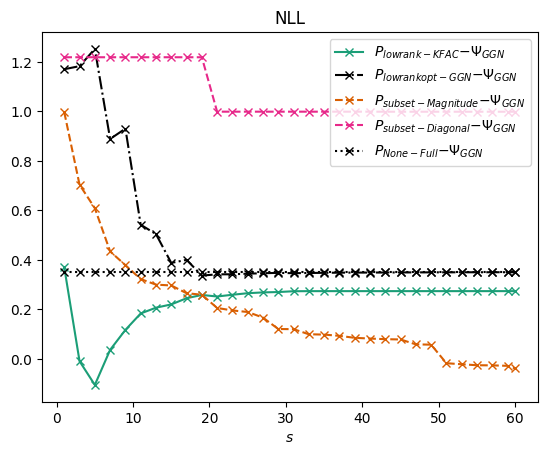

In [15]:
plt.tight_layout()
for (p, psi) in methods_evaluate:
    try:
        p_group, p_name = p.split("-")
    except:
        p_group, p_name = "None", "None"
    p_name_plot = get_p_name(p_name)
    # generate label
    psi_name_plot = get_psi_name(psi)
    label_method = f"{get_p_method(p_group)}-"
    label_psi = fr"$-\Psi_{{{psi_name_plot}}}$"
    label = fr"$P_{{{label_method}{p_name_plot}}}${label_psi}"
    
    plt.plot(s_list, metrics[psi][p]["nll"],
            label=label,
            color=get_color(p_name) if psi_name_plot=="GGN" else get_color2(p_name),
            linestyle=get_linestyle(p_group),
            marker="x")
    plt.title("NLL")
    plt.xlabel(r"$s$")
plt.legend()

This plot shows that the NLL isn't suitable to evaluate the subspace models. For example $P_{\mathrm{lowrank-KFAC}}$ first improves in terms of the NLL, but starts to get worse after $s=6$. This means the NLL suggest that the subspace models for $s>6$ should be worse than the subspace models for $s\leq 6$. However, the subspace model for $s>6$ contains all the (uncertainty) information than the lower dimensional subspace models have.